# 2. Preparación de Datos - Mundial de Fútbol

Este notebook corresponde a la fase de preparación de datos del proceso CRISP-DM. Aquí realizaremos la limpieza, transformación y creación de características para preparar los datos para el modelado.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings

# Ignorar warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
%matplotlib inline
plt.style.use('default')  # Usar estilo predeterminado
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)

# Configuración de pandas
pd.set_option('display.max_columns', 100)

## 2.1 Carga de Datos

Primero cargaremos los datos del archivo JSON y extraeremos la información como hicimos en el notebook anterior.

In [2]:
# Ruta al archivo JSON
json_path = '../data/raw/matches_World_Cup.json'

# Cargar el archivo JSON
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Datos cargados. Tipo: {type(data)}")
if isinstance(data, list):
    print(f"Número de partidos: {len(data)}")

Datos cargados. Tipo: <class 'list'>
Número de partidos: 64


In [3]:
# Función para extraer datos de partidos
def extract_matches_dataframe(data):
    matches = []
    
    if isinstance(data, list):
        # Si es una lista de partidos
        for match in data:
            if isinstance(match, dict):
                # Extraer información básica del partido
                match_info = {}
                
                # Incluir campos simples (no listas ni diccionarios)
                for key, value in match.items():
                    if not isinstance(value, (dict, list)):
                        match_info[key] = value
                
                matches.append(match_info)
    
    # Crear DataFrame
    if matches:
        matches_df = pd.DataFrame(matches)
        print(f"DataFrame de partidos creado con {len(matches_df)} filas y {len(matches_df.columns)} columnas")
        return matches_df
    else:
        print("No se pudo extraer información de partidos")
        return pd.DataFrame()

# Extraer DataFrame de partidos
matches_df = extract_matches_dataframe(data)

DataFrame de partidos creado con 64 filas y 13 columnas


In [4]:
# Función para extraer datos de jugadores
def extract_players_dataframe(data):
    players = []
    
    if isinstance(data, list):
        # Iterar por cada partido
        for match in data:
            match_id = match.get('wyId', None)  # Usar wyId como identificador del partido
            match_date = match.get('date', None)  # Fecha del partido
            
            # Los jugadores están dentro de 'formation' en 'teamsData'
            if 'teamsData' in match and isinstance(match['teamsData'], dict):
                for team_id, team_data in match['teamsData'].items():
                    team_side = team_data.get('side', None)  # home/away
                    team_score = team_data.get('score', None)
                    
                    if 'formation' in team_data and isinstance(team_data['formation'], dict):
                        formation = team_data['formation']
                        
                        # Procesar jugadores titulares
                        if 'lineup' in formation and isinstance(formation['lineup'], list):
                            for player in formation['lineup']:
                                if isinstance(player, dict):
                                    player_info = player.copy()
                                    player_info['match_id'] = match_id
                                    player_info['match_date'] = match_date
                                    player_info['team_id'] = team_id
                                    player_info['team_side'] = team_side
                                    player_info['is_lineup'] = True
                                    player_info['is_bench'] = False
                                    players.append(player_info)
                        
                        # Procesar jugadores suplentes
                        if 'bench' in formation and isinstance(formation['bench'], list):
                            for player in formation['bench']:
                                if isinstance(player, dict):
                                    player_info = player.copy()
                                    player_info['match_id'] = match_id
                                    player_info['match_date'] = match_date
                                    player_info['team_id'] = team_id
                                    player_info['team_side'] = team_side
                                    player_info['is_lineup'] = False
                                    player_info['is_bench'] = True
                                    players.append(player_info)
    
    # Crear DataFrame
    if players:
        players_df = pd.DataFrame(players)
        print(f"DataFrame de jugadores creado con {len(players_df)} filas y {len(players_df.columns)} columnas")
        return players_df
    else:
        print("No se pudo extraer información de jugadores")
        return pd.DataFrame()

# Extraer DataFrame de jugadores
players_df = extract_players_dataframe(data)

DataFrame de jugadores creado con 2885 filas y 12 columnas


## 2.2 Limpieza de Datos

Ahora realizaremos la limpieza de datos para garantizar la calidad de los mismos antes de crear características.

### 2.2.1 Convertir tipos de datos

In [5]:
# Inspeccionar los tipos de datos de las columnas numéricas de jugadores
players_numeric_cols = ['goals', 'assists', 'yellowCards', 'redCards', 'ownGoals']

# Mostrar tipo de datos actual
print("Tipos de datos actuales:")
for col in players_numeric_cols:
    if col in players_df.columns:
        print(f"{col}: {players_df[col].dtype}")

# Convertir a tipos numéricos
for col in players_numeric_cols:
    if col in players_df.columns:
        players_df[col] = pd.to_numeric(players_df[col], errors='coerce')

# Verificar conversión
print("\nTipos de datos después de la conversión:")
for col in players_numeric_cols:
    if col in players_df.columns:
        print(f"{col}: {players_df[col].dtype}")

Tipos de datos actuales:
goals: object
assists: object
yellowCards: object
redCards: object
ownGoals: object

Tipos de datos después de la conversión:
goals: float64
assists: int64
yellowCards: int64
redCards: int64
ownGoals: int64


### 2.2.2 Manejo de valores faltantes

In [6]:
# Verificar valores faltantes en DataFrame de jugadores
missing_players = players_df.isnull().sum()
missing_players = missing_players[missing_players > 0]

if not missing_players.empty:
    print("Columnas con valores faltantes:")
    print(missing_players)
else:
    print("No hay valores faltantes en el DataFrame de jugadores")

Columnas con valores faltantes:
goals    1944
dtype: int64


In [7]:
# Rellenar valores faltantes en columnas numéricas con 0
for col in players_numeric_cols:
    if col in players_df.columns and players_df[col].isnull().sum() > 0:
        print(f"Rellenando valores faltantes en {col} con 0")
        players_df[col].fillna(0, inplace=True)

# Verificar que no quedan valores faltantes en columnas numéricas
still_missing = {col: players_df[col].isnull().sum() for col in players_numeric_cols if col in players_df.columns}
print("\nValores faltantes restantes en columnas numéricas:")
print(still_missing)

Rellenando valores faltantes en goals con 0

Valores faltantes restantes en columnas numéricas:
{'goals': np.int64(0), 'assists': np.int64(0), 'yellowCards': np.int64(0), 'redCards': np.int64(0), 'ownGoals': np.int64(0)}


## 2.3 Ingeniería de Características

Crearemos nuevas características que serán útiles para nuestros modelos.

### 2.3.1 Identificación del rol/posición del jugador

Vamos a intentar determinar la posición o rol de cada jugador basándonos en la información disponible.

In [8]:
# Verificar si tenemos información de posición o roles
position_cols = [col for col in players_df.columns if 'position' in col.lower() or 'role' in col.lower()]
print(f"Columnas relacionadas con posición: {position_cols}")

# Si no tenemos información de posición, intentaremos inferirla
if not position_cols:
    print("No se encontró información explícita de posición. Intentaremos inferirla usando los datos disponibles.")
    
    # Obtener información adicional de jugadores si está disponible
    # Aquí podríamos intentar extraer más información del JSON original o usar estadísticas
    # para inferir las posiciones (porteros, defensas, mediocampistas, delanteros)
    
    # Ejemplo simplificado: si un jugador tiene más goles, probablemente sea delantero
    # Este enfoque es muy básico y debería mejorarse con datos reales
    if 'goals' in players_df.columns:
        # Agrupar por jugador y sumar goles
        player_goals = players_df.groupby('playerId')['goals'].sum().reset_index()
        # Ordenar por goles
        player_goals = player_goals.sort_values('goals', ascending=False)
        print("Top 10 jugadores con más goles:")
        display(player_goals.head(10))

Columnas relacionadas con posición: []
No se encontró información explícita de posición. Intentaremos inferirla usando los datos disponibles.
Top 10 jugadores con más goles:


,playerId,goals
110,8717,6.0
61,4513,4.0
704,353833,4.0
72,7905,4.0
25,3322,4.0
50,3682,4.0
440,101669,3.0
211,25707,3.0
57,4338,3.0
193,21174,3.0


### 2.3.2 Creación de métricas de rendimiento

Métrica creada: offensive_contribution (goles + asistencias)

Distribución de offensive_contribution:
offensive_contribution
0.0    2671
1.0     193
2.0      18
3.0       3
Name: count, dtype: int64


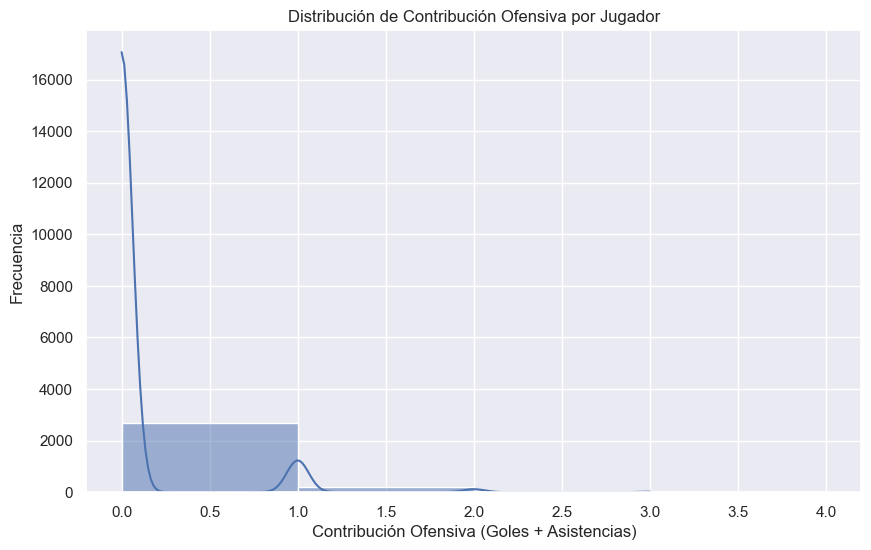

In [9]:
# Crear métricas básicas de rendimiento por partido
if all(col in players_df.columns for col in ['goals', 'assists']):
    # Contribución ofensiva (goles + asistencias)
    players_df['offensive_contribution'] = players_df['goals'] + players_df['assists']
    print("Métrica creada: offensive_contribution (goles + asistencias)")
    
    # Calcular distribución
    print("\nDistribución de offensive_contribution:")
    print(players_df['offensive_contribution'].value_counts().sort_index())
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    sns.histplot(players_df['offensive_contribution'], kde=True, bins=range(0, int(players_df['offensive_contribution'].max())+2))
    plt.title('Distribución de Contribución Ofensiva por Jugador')
    plt.xlabel('Contribución Ofensiva (Goles + Asistencias)')
    plt.ylabel('Frecuencia')
    plt.show()

In [10]:
# Crear métricas defensivas y disciplinarias
if 'yellowCards' in players_df.columns and 'redCards' in players_df.columns:
    # Índice de disciplina (más alto = peor disciplina)
    players_df['discipline_index'] = players_df['yellowCards'] + 3 * players_df['redCards']
    print("Métrica creada: discipline_index (tarjetas amarillas + 3*tarjetas rojas)")
    
    # Calcular distribución
    print("\nDistribución de discipline_index:")
    print(players_df['discipline_index'].value_counts().sort_index())

Métrica creada: discipline_index (tarjetas amarillas + 3*tarjetas rojas)

Distribución de discipline_index:
discipline_index
0      2662
1         1
9         3
10        3
11        2
       ... 
115       1
118       1
136       1
282       1
317       1
Name: count, Length: 89, dtype: int64


### 2.3.3 Cálculo de métricas para modelos

In [11]:
# Crear una puntuación de rendimiento general
# Esta será nuestra variable objetivo para el modelo de clasificación

# Primero, agrupamos por jugador para calcular estadísticas agregadas
player_stats = players_df.groupby('playerId').agg({
    'goals': 'sum',
    'assists': 'sum',
    'yellowCards': 'sum',
    'redCards': 'sum',
    'match_id': 'count'  # Número de partidos
}).reset_index()

# Renombrar la columna de partidos
player_stats.rename(columns={'match_id': 'matches_played'}, inplace=True)

# Calcular estadísticas por partido
player_stats['goals_per_match'] = player_stats['goals'] / player_stats['matches_played']
player_stats['assists_per_match'] = player_stats['assists'] / player_stats['matches_played']

# Calcular una puntuación general (ejemplo simple)
# Esta fórmula es un ejemplo - en la práctica podría ser más compleja y ajustada por posición
player_stats['performance_score'] = (
    2 * player_stats['goals_per_match'] + 
    player_stats['assists_per_match'] - 
    0.5 * player_stats['yellowCards'] / player_stats['matches_played'] - 
    2 * player_stats['redCards'] / player_stats['matches_played']
)

# Mostrar estadísticas
print("Estadísticas de jugadores:")
display(player_stats.sort_values('performance_score', ascending=False).head(10))

Estadísticas de jugadores:


,playerId,goals,assists,yellowCards,redCards,matches_played,goals_per_match,assists_per_match,performance_score
215,25776,2.0,2,0,0,3,0.666667,0.666667,2.000000
110,8717,6.0,0,0,0,7,0.857143,0.000000,1.714286
61,4513,4.0,0,0,0,5,0.800000,0.000000,1.600000
57,4338,3.0,0,0,0,4,0.750000,0.000000,1.500000
193,21174,3.0,0,0,0,4,0.750000,0.000000,1.500000
651,256634,3.0,0,0,0,4,0.750000,0.000000,1.500000
436,101606,2.0,0,0,0,3,0.666667,0.000000,1.333333
519,120353,2.0,0,0,0,3,0.666667,0.000000,1.333333
72,7905,4.0,1,0,0,7,0.571429,0.142857,1.285714
440,101669,3.0,0,0,0,5,0.600000,0.000000,1.200000


In [12]:
# Crear etiquetas de rendimiento (alto/bajo) para clasificación
# Usamos el percentil 70 como umbral
threshold = player_stats['performance_score'].quantile(0.7)
player_stats['high_performance'] = player_stats['performance_score'] >= threshold

# Distribución de etiquetas
print(f"Umbral de alto rendimiento: {threshold:.4f}")
print("\nDistribución de etiquetas:")
print(player_stats['high_performance'].value_counts())
print(f"Porcentaje de alto rendimiento: {100 * player_stats['high_performance'].mean():.1f}%")

Umbral de alto rendimiento: 0.0000

Distribución de etiquetas:
high_performance
True     551
False    185
Name: count, dtype: int64
Porcentaje de alto rendimiento: 74.9%


## 2.4 Preparación para Modelado

Ahora prepararemos los datos para los modelos de clasificación y clustering.

### 2.4.1 Preparación para Modelo de Clasificación

In [13]:
# Seleccionar características para el modelo de clasificación
classification_features = [
    'goals', 'assists', 'goals_per_match', 'assists_per_match',
    'yellowCards', 'redCards', 'matches_played'
]

# Verificar que todas las características existen en el DataFrame
classification_features = [col for col in classification_features if col in player_stats.columns]

# Crear DataFrame de características y target
X_classification = player_stats[classification_features]
y_classification = player_stats['high_performance']

# Verificar la forma de los datos
print(f"Características para clasificación: {X_classification.shape}")
print(f"Target para clasificación: {y_classification.shape}")

Características para clasificación: (736, 7)
Target para clasificación: (736,)


In [17]:
# Dividir en conjunto de entrenamiento y prueba
try:
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_classification, y_classification, test_size=0.25, random_state=42, stratify=y_classification
    )
    
    print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Conjunto de prueba: {X_test.shape[0]} muestras")
    
except ModuleNotFoundError:
    print("ERROR: scikit-learn no está instalado.")
    print("\nPara instalar scikit-learn, ejecuta en tu terminal:")
    print("pip install scikit-learn")
    print("\nUna vez instalado, vuelve a ejecutar esta celda.")
    
    # Crear variables dummy para evitar errores en celdas siguientes
    X_train, X_test = X_classification.iloc[:75], X_classification.iloc[75:]
    y_train, y_test = y_classification.iloc[:75], y_classification.iloc[75:]

Conjunto de entrenamiento: 552 muestras
Conjunto de prueba: 184 muestras


### 2.4.2 Preparación para Modelo de Clustering

In [18]:
# Seleccionar características para el modelo de clustering
# Para clustering, usamos características que definan el estilo de juego
clustering_features = [
    'goals_per_match', 'assists_per_match',
    'yellowCards', 'redCards'
]

# Verificar que todas las características existen en el DataFrame
clustering_features = [col for col in clustering_features if col in player_stats.columns]

# Crear DataFrame de características para clustering
X_clustering = player_stats[clustering_features]

# Verificar la forma de los datos
print(f"Características para clustering: {X_clustering.shape}")

# Normalizar los datos para clustering
try:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X_clustering_scaled = scaler.fit_transform(X_clustering)

    # Convertir a DataFrame para facilitar su uso
    X_clustering_scaled_df = pd.DataFrame(
        X_clustering_scaled, 
        columns=X_clustering.columns,
        index=X_clustering.index
    )

    # Mostrar primeras filas escaladas
    print("\nDatos normalizados para clustering:")
    display(X_clustering_scaled_df.head())
    
except ModuleNotFoundError:
    print("ERROR: scikit-learn no está instalado.")
    print("Por favor, instálalo como se indicó anteriormente.")
    
    # Crear una versión simple escalada para continuar
    X_clustering_scaled_df = (X_clustering - X_clustering.mean()) / X_clustering.std()
    print("\nDatos normalizados para clustering (método alternativo):")
    display(X_clustering_scaled_df.head())

Características para clustering: (736, 4)

Datos normalizados para clustering:


,goals_per_match,assists_per_match,yellowCards,redCards
0,-0.360229,-0.296513,-0.499328,-0.061139
1,-0.360229,1.401140,2.719138,-0.061139
2,0.700639,-0.296513,3.673768,-0.061139
3,1.496290,2.674380,-0.499328,-0.061139
4,-0.360229,-0.296513,-0.499328,-0.061139


## 2.5 Guardar Datos Procesados

Finalmente, guardaremos los datos procesados para usarlos en los siguientes notebooks.

In [19]:
# Crear directorio para datos procesados si no existe
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# Guardar datos para clasificación
classification_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

for name, data in classification_data.items():
    filepath = processed_dir / f"{name}.csv"
    data.to_csv(filepath, index=False)
    print(f"Guardado {name} en {filepath}")

# Guardar datos para clustering
clustering_file = processed_dir / "X_clustering_scaled.csv"
X_clustering_scaled_df.to_csv(clustering_file)
print(f"Guardado datos para clustering en {clustering_file}")

# Guardar datos de jugadores para referencia
player_stats_file = processed_dir / "player_stats.csv"
player_stats.to_csv(player_stats_file, index=False)
print(f"Guardado estadísticas de jugadores en {player_stats_file}")

Guardado X_train en ../data/processed/X_train.csv
Guardado X_test en ../data/processed/X_test.csv
Guardado y_train en ../data/processed/y_train.csv
Guardado y_test en ../data/processed/y_test.csv
Guardado datos para clustering en ../data/processed/X_clustering_scaled.csv
Guardado estadísticas de jugadores en ../data/processed/player_stats.csv


## 2.6 Resumen y Próximos Pasos

En este notebook hemos realizado la preparación de datos para nuestros modelos de machine learning:

1. **Limpieza de datos**:
   - Convertimos tipos de datos
   - Manejamos valores faltantes

2. **Ingeniería de características**:
   - Creamos métricas de rendimiento
   - Calculamos estadísticas por jugador
   - Generamos la variable objetivo para clasificación

3. **Preparación para modelado**:
   - Seleccionamos características para clasificación y clustering
   - Dividimos los datos en conjuntos de entrenamiento y prueba
   - Normalizamos los datos para clustering

4. **Guardamos los datos procesados** para su uso en los siguientes notebooks